# 예측모델 만들기

## Preprocessing

### improt library

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 데이터 가져오기

In [0]:
data = pd.read_csv('gdrive/My Drive/공모전/Lpoint/데이터셋 만들기/lotte_drama.csv')
data.rename(columns = {'CLAC1_NM':'분류','CLAC2_NM':'중분류'},inplace = True)
data = pd.get_dummies(data,columns = ['분류','중분류'])
target = pd.read_csv('gdrive/My Drive/공모전/Lpoint/선호지수 만들기/score1.csv')
target2 = pd.read_csv('gdrive/My Drive/공모전/Lpoint/선호지수 만들기/score2.csv')
dataset = pd.merge(data,target, how = 'inner', on=['LABEL']).set_index('LABEL')
dataset2 = pd.merge(data,target2, how = 'inner', on=['LABEL']).set_index('LABEL')

In [0]:
data2 = pd.read_csv('gdrive/My Drive/공모전/Lpoint/데이터셋 만들기/mlotte_drama.csv')
data2.rename(columns = {'CLAC1_NM':'분류','CLAC2_NM':'중분류'},inplace = True)
data2 = pd.get_dummies(data2,columns = ['분류','중분류'])
target21 = pd.read_csv('gdrive/My Drive/공모전/Lpoint/선호지수 만들기/score12.csv')
target22 = pd.read_csv('gdrive/My Drive/공모전/Lpoint/선호지수 만들기/score22.csv')
testset = pd.merge(data2,target21, how = 'inner', on=['LABEL']).set_index('LABEL')
testset2 = pd.merge(data2,target22, how = 'inner', on=['LABEL']).set_index('LABEL')

In [4]:
dataset[['PD_BUY_AM','PD_BUY_CT','PD_SALES','BRA_SC','CLAC3_SC','SCORE']].corr('pearson')

,PD_BUY_AM,PD_BUY_CT,PD_SALES,BRA_SC,CLAC3_SC,SCORE
PD_BUY_AM,1.000000,-0.064173,0.061755,-0.054930,0.015493,0.038257
PD_BUY_CT,-0.064173,1.000000,0.807087,0.003129,0.077067,0.016302
PD_SALES,0.061755,0.807087,1.000000,0.012561,0.050767,0.014349
BRA_SC,-0.054930,0.003129,0.012561,1.000000,0.041518,0.032633
CLAC3_SC,0.015493,0.077067,0.050767,0.041518,1.000000,-0.064744
SCORE,0.038257,0.016302,0.014349,0.032633,-0.064744,1.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2efefca588>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2efefca588>)

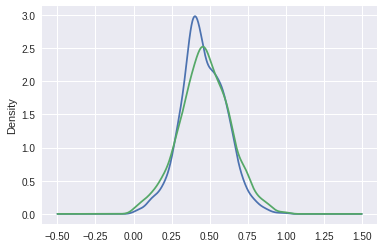

In [5]:
dataset['SCORE'].plot.density(), dataset2['SCORE2'].plot.density()

### 데이터 전처리

In [0]:
# bins = [dataset['SCORE'].quantile(i*0.25) for i in range(5)]
bins = [i*.25 for i in range(5)]
labels = ['Fine','Good','Great','Perfect']
dataset['SCORE']=pd.cut(dataset['SCORE'], bins = bins, labels = labels)
dataset2['SCORE2']=pd.cut(dataset2['SCORE2'], bins = bins, labels = labels)
testset['SCORE']=pd.cut(testset['SCORE'], bins = bins, labels = labels)
testset2['SCORE2']=pd.cut(testset2['SCORE2'], bins = bins, labels = labels)

In [0]:
dataset['SCORE'][dataset['SCORE'].isnull()] = 'Fine'
dataset2['SCORE2'][dataset2['SCORE2'].isnull()] = 'Fine'
testset['SCORE'][testset['SCORE'].isnull()] = 'Fine'
testset2['SCORE2'][testset2['SCORE2'].isnull()] = 'Fine'

In [0]:
# trainset = dataset2[:-2735] 
# testset = testset[-2735:]
# # X_train, y_train = trainset.iloc[:,:-1], trainset['SCORE2']
# # X_test, y_test = testset.iloc[:,:-1], testset['SCORE2']
# trainset = dataset[:-2735] 
# testset = dataset[-2735:]
# X_train, y_train = trainset.iloc[:,:-1], trainset['SCORE']
# X_test, y_test = testset.iloc[:,:-1], testset['SCORE']
# X_train, y_train = dataset.iloc[:,:-1], dataset['SCORE']
# X_test, y_test = testset.iloc[:,:-1], testset['SCORE']
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [0]:
X, y = dataset.iloc[:,:-1], dataset['SCORE']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.preprocessing import StandardScaler

# Scale the variables to have 0 mean and unit variance
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [11]:
dataset['SCORE'].describe()
# dataset2['SCORE2'].describe()

count     4157
unique       4
top       Good
freq      2298
Name: SCORE, dtype: object

## Models

In [0]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

In [0]:
from sklearn.metrics import accuracy_score

def evaluate(model, test_features, test_labels):
    predicted = model.predict(test_features)
    accuracy = accuracy_score(y_test, predicted)
    print('Model Performance')
    print('Accuracy = {:0.3f}%.'.format(accuracy))
    
    return accuracy

### Random Forest Classifier

#### simple model

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [76]:
from sklearn.metrics import accuracy_score

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

# print(f'Out-of-bag score estimate: {best_grid.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Mean accuracy score: 0.62


In [77]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(dataset.columns, rf.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values[:10], headers, tablefmt="plain"))

name           score
PD_BUY_AM  0.081919
PD_SALES   0.0780156
BRA_SC     0.0447314
PD_BUY_CT  0.0394075
Seoul      0.0389472
Mobile     0.038773
CLAC3_SC   0.0376324
F_40       0.0357797
F_30       0.0323362
Desktop    0.0287016


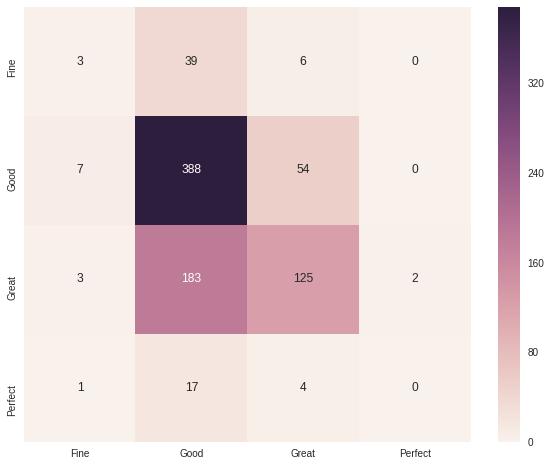

In [78]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10,8))
cm = pd.DataFrame(confusion_matrix(y_test, predicted))

sns.heatmap(cm, annot=True, fmt="d", xticklabels = labels, yticklabels = labels, annot_kws={"size": 12})

#### Parameter Tuning

##### Randomized Search

In [14]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in RandomForest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [15]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 54.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [16]:
base_model = RandomForestClassifier(n_estimators = 200, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 0.618%.
Model Performance
Accuracy = 0.620%.
Improvement of 0.39%.


In [17]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(dataset.columns, best_random.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values[:10], headers, tablefmt="plain"))

name                 score
중분류_메이크업  0.0852117
PD_BUY_AM        0.0743547
중분류_보석      0.0639513
PD_SALES         0.0549781
Desktop          0.0424225
PD_BUY_CT        0.0402224
BRA_SC           0.0399527
Mobile           0.0389773
NOT_SIGNED       0.038411
CLAC3_SC         0.0340616


##### Grid Search

In [0]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True,False],
    'max_depth': [5, 10, 20],
    'max_features': ['auto'],
    'min_samples_leaf': [2, 4, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 500, 1000, 1800, 2000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [19]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 64.4min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 92.6min finished


{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [20]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


Model Performance
Accuracy = 0.617%.
Improvement of -0.19%.


In [21]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(dataset.columns, best_grid.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values[:10], headers, tablefmt="plain"))

name                 score
중분류_메이크업  0.0894808
PD_BUY_AM        0.0731941
중분류_보석      0.0679949
PD_SALES         0.05489
Desktop          0.0452971
NOT_SIGNED       0.0406702
BRA_SC           0.0395713
Mobile           0.0381016
PD_BUY_CT        0.0358214
F_40             0.0318628


### Extra Forest Classifier

##### Randomized Search

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in ExtraTrees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
ef = ExtraTreesClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
ef_random = RandomizedSearchCV(estimator = ef, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
ef_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [0]:
base_model = ExtraTreesClassifier(n_estimators = 200, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = ef_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 0.553%.
Model Performance
Accuracy = 0.571%.
Improvement of 3.27%.


In [0]:
ef_random.best_estimator_

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=10, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### AdaBoost

##### Randomized Search

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in AdaBoost
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 10)]
# Number of features to consider at every split
learning_rate = [x*0.05 for x in range(1,21)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate' : learning_rate 
              }
print(random_grid)

{'n_estimators': [20, 240, 460, 680, 900, 1120, 1340, 1560, 1780, 2000], 'learning_rate': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0]}


In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
ab = AdaBoostClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
ab_random = RandomizedSearchCV(estimator = ab, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
ab_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 38.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [20, 240, 460, 680, 900, 1120, 1340, 1560, 1780, 2000], 'learning_rate': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [0]:
base_model = AdaBoostClassifier(n_estimators = 200, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = ab_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 0.479%.
Model Performance
Accuracy = 0.576%.
Improvement of 20.18%.


In [0]:
ab_random.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.35000000000000003, n_estimators=20,
          random_state=None)

##### Grid Search

In [0]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [10, 20, 50, 100, 200]
}
# Create a based model
ad = AdaBoostClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ad, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [42]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   46.1s finished


{'learning_rate': 0.1, 'n_estimators': 100}

In [43]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


Model Performance
Accuracy = 0.574%.
Improvement of 4.31%.


In [44]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(dataset.columns, best_grid.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values[:10], headers, tablefmt="plain"))

name               score
Desktop             0.15
PD_SALES            0.14
중분류_메이크업     0.13
BRA_SC              0.07
NOT_SIGNED          0.07
중분류_보석         0.05
중분류_여성화       0.05
PD_BUY_CT           0.04
Gyeongnam           0.04
F_30                0.03


### Gradient Boost

##### Randomized Search

In [15]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in Gradient Boost
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [16]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb = GradientBoostingClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 63.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 122.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [21]:
base_model = GradientBoostingClassifier(n_estimators = 200, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = gb_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 0.550%.
Model Performance
Accuracy = 0.537%.
Improvement of -2.41%.


In [22]:
gb_random.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=80,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=4, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=1600,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [23]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(dataset.columns, best_random.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values[:10], headers, tablefmt="plain"))

name                 score
PD_BUY_AM        0.13629
PD_SALES         0.112395
BRA_SC           0.0789212
CLAC3_SC         0.054534
F_40             0.0427581
Desktop          0.0393565
중분류_메이크업  0.0342877
Mobile           0.0342623
F_30             0.0318065
Seoul            0.0317452
